# Hidden Unit Dynamics
## Encoder Networks

The $N - K - N$ Encoder task is a simple supervised learning task which has been designed to help us understand the hidden unit dynamics of neural networks, and also serves as a simplified version of the Autoencoders we will meet in Week 6.

<img src="encoder networks.png"/>

For this task, the $j$th item follows a **one-hot encoding**, with its $j$th input equal to $1$ and all other inputs equal to $0$. The target output is exactly the same as the input. However, the challenge lies in the fact that the input must be "compressed" to fit through the bottleneck of the $K$ hidden nodes where $K \leq N$, and then reconstructed from this lower dimensional space.

Run this code, and then click on "encoder.png" to visualize the hidden unit space for a $9 - 2 - 9$ Encoder network.

ep100: loss =  0.3487
ep200: loss =  0.2906
ep300: loss =  0.2004
ep400: loss =  0.1845
ep500: loss =  0.1736
ep600: loss =  0.1627
ep700: loss =  0.1528
ep800: loss =  0.1452
ep900: loss =  0.1388
ep1000: loss =  0.1332
ep1100: loss =  0.1281
ep1200: loss =  0.1235
ep1300: loss =  0.1193
ep1400: loss =  0.1155
ep1500: loss =  0.1120
ep1600: loss =  0.1087
ep1700: loss =  0.1056
ep1800: loss =  0.1028
ep1900: loss =  0.1001
ep2000: loss =  0.0976
ep2100: loss =  0.0952
ep2200: loss =  0.0929
ep2300: loss =  0.0908
ep2400: loss =  0.0888
ep2500: loss =  0.0869
ep2600: loss =  0.0851
ep2700: loss =  0.0834
ep2800: loss =  0.0818
ep2900: loss =  0.0802
ep3000: loss =  0.0787
ep3100: loss =  0.0773
ep3200: loss =  0.0759
ep3300: loss =  0.0746
ep3400: loss =  0.0734
ep3500: loss =  0.0722
ep3600: loss =  0.0710
ep3700: loss =  0.0699
ep3800: loss =  0.0688
ep3900: loss =  0.0677
ep4000: loss =  0.0666
ep4100: loss =  0.0656
ep4200: loss =  0.0645
ep4300: loss =  0.0635
ep4400: loss =  0.06

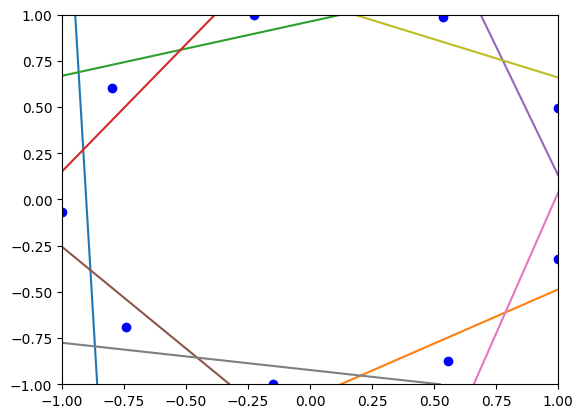

In [2]:
# encoder_main.py
# COMP9444, CSE, UNSW

from __future__ import print_function
import torch
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt
#import numpy as np


class EncModel(torch.nn.Module):
    # fully connected two-layer network
    def __init__(self, num_input, num_hid, num_out):
        super(EncModel, self).__init__()
        self.in_hid  = torch.nn.Linear(num_input, num_hid)
        self.hid_out = torch.nn.Linear(num_hid, num_out)
    def forward(self, input):
        hid_sum = self.in_hid(input)
        hidden  = torch.tanh(hid_sum)
        out_sum = self.hid_out(hidden)
        output  = torch.sigmoid(out_sum)
        return(output)

def plot_hidden(net):
    # plot the hidden unit dynamics of the network
    plt.xlim(-1, 1), plt.ylim(-1, 1) # limits of x and y axes

    # input to hidden weights and biases
    weight = net.in_hid.weight.data.cpu()
    bias   = net.in_hid.bias.data.cpu()

    num_in  = net.in_hid.weight.data.size()[1]
    num_out = net.hid_out.weight.data.size()[0]

    # draw a dot to show where each input is mapped to in hidden unit space
    P = torch.tanh(weight + bias.unsqueeze(1).repeat(1,num_in))
    plt.plot(P[0, :], P[1, :], 'bo')

    # draw a line interval to show the decision boundary of each output
    for i in range(num_out):

        A = net.hid_out.weight.data.cpu()[i, 0]
        B = net.hid_out.weight.data.cpu()[i, 1]
        C = net.hid_out.bias.data.cpu()[i]

        j = 0
        if A == 0:
            if B != 0:
                y0 = -C/B
                if -1 < y0 < 1:
                    j = 2
                    plt.plot([-1, 1], [y0, y0])
        elif B == 0:
            if A != 0:
                x0 = -C/A
                if -1 < x0 < 1:
                    plt.plot([x0, x0], [-1, 1])
        else:
            x = torch.zeros(2)
            y = torch.zeros(2)
            y0 = (A - C) / B
            if -1 <= y0 <= 1:
                x[j] = -1
                y[j] =  y0
                j = j+1
            y0 = (-A-C)/B
            if -1 <= y0 <= 1:
                x[j] =  1
                y[j] =  y0
                j = j+1
            x0 = (B - C) / A
            if j < 2 and -1 <= x0 <= 1:
                x[j] =  x0
                y[j] = -1
                j = j+1
            x0 = (-B - C) / A
            if j < 2 and -1 <= x0 <= 1:
                x[j] =  x0
                y[j] =  1
                j = j + 1
            if j > 1:
                plt.plot(x, y)

def main():
    target = torch.eye(9)

    num_in  = target.size()[0]
    num_out = target.size()[1]

    # input is one-hot with same number of rows as target
    input  = torch.eye(num_in)
    target = torch.eye(num_in)

    xor_dataset  = torch.utils.data.TensorDataset(input, target)
    train_loader = torch.utils.data.DataLoader(xor_dataset, batch_size=num_in)

    # create neural network according to model specification
    net = EncModel(num_in, 2, num_out)

    # initialize weights, but set biases to zero
    net.in_hid.weight.data.normal_(0, 0.001)
    net.hid_out.weight.data.normal_(0, 0.001)
    net.in_hid.bias.data.zero_()
    net.hid_out.bias.data.zero_()

    # SGD optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.4, momentum=0.9)

    loss = 1.0
    epoch = 0

    while epoch < 100000 and loss > 0.02:
        epoch = epoch+1
        for batch_id, (data, target) in enumerate(train_loader):
            # data, target = data.to(device), target.to(device)
            optimizer.zero_grad() # zero the gradients
            output = net(data)    # apply network
            loss = F.binary_cross_entropy(output,target)
            loss.backward()       # compute gradients
            optimizer.step()      # update weights
            if epoch % 100 == 0:
                print('ep%3d: loss = %7.4f' % (epoch, loss.item()))

    plot_hidden(net)
    plt.savefig("encoder.png")

if __name__ == '__main__':
    main()

Each dot in this image corresponds to a particular input pattern, and shows us the activations of the two hidden nodes (horizontal and vertical axis) when this input pattern is fed to the network. Each line in the image corresponds to a particular output node, and shows the dividing line between those points in hidden unit space for which this output is less than $0.5$, and those for which it is greater than $0.5$.

from ed message forum

<img src="week 2 images/hidden unit dynamics.png"/>

<img src="week 2 images/hidden unit dynamics screenshot 1.png"/>

<img src="week 2 images/hidden unit dynamics screenshot 2.png"/>